In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as pyplot
import imutils

import tensorflow as tf
import keras.layers as layers
import keras.models as models
import keras.optimizers as optimizers

import keras

from keras import backend as K
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout
from keras.models import Model
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [2]:
def image_generator(image_numbers,batch_size=8):
    i = 0
    while True:
        batch_input = []
        batch_output = []
        
        batch_numbers = np.random.choice(image_numbers, batch_size)
        
        for i in batch_numbers:
            img = cv2.cvtColor(cv2.imread('augmented/' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
            m = cv2.cvtColor(cv2.imread('augmented/' + str(i) + '_mask.png'), cv2.COLOR_BGRA2GRAY)
            batch_input.append(img / 255.0)
            batch_output.append(m.reshape((m.shape[0], m.shape[1], 1))/255.0)

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield (batch_x, batch_y)


In [3]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [4]:
inp = models.Input((None, None, 3))
activation = 'elu'
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(inp)
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c1 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c2 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c3 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c4 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c5 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = concatenate([l, c5])
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)

l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = concatenate([l, c4])
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)

l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = concatenate([l, c3])
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)

l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = concatenate([l, c2])
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)

l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = concatenate([l, c1])
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)

out = layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal', padding='same')(l)

model = models.Model(inp, out)

In [5]:
model.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy', metrics=[
    mean_iou
])

In [4]:
#model.summary()
model = keras.models.load_model('bill-segmentation-model-0.9797.h5', custom_objects={'mean_iou': mean_iou})

In [7]:
p = np.random.permutation(np.arange(1, 1101))
model.fit_generator(
          image_generator(p[:1000]),
          validation_data=image_generator(p[1000:]),
          validation_steps=5,
          steps_per_epoch=100,
          epochs=10000,
          callbacks=[
              keras.callbacks.EarlyStopping(monitor='val_mean_iou', patience=30, verbose=False, mode='max', baseline=None, restore_best_weights=True)
          ])

Epoch 1/10000
100/100 [==============================] - 52s 521ms/step - loss: 0.0138 - mean_iou: 0.9719 - val_loss: 0.0156 - val_mean_iou: 0.9811
Epoch 2/10000
100/100 [==============================] - 45s 446ms/step - loss: 0.0225 - mean_iou: 0.9782 - val_loss: 0.0150 - val_mean_iou: 0.9760
Epoch 3/10000
100/100 [==============================] - 44s 440ms/step - loss: 0.0156 - mean_iou: 0.9764 - val_loss: 0.0124 - val_mean_iou: 0.9769
Epoch 4/10000
100/100 [==============================] - 46s 456ms/step - loss: 0.0137 - mean_iou: 0.9775 - val_loss: 0.0135 - val_mean_iou: 0.9779
Epoch 5/10000
100/100 [==============================] - 45s 452ms/step - loss: 0.0146 - mean_iou: 0.9782 - val_loss: 0.0152 - val_mean_iou: 0.9784
Epoch 6/10000
100/100 [==============================] - 45s 449ms/step - loss: 0.0129 - mean_iou: 0.9786 - val_loss: 0.0164 - val_mean_iou: 0.9789
Epoch 7/10000
100/100 [==============================] - 45s 451ms/step - loss: 0.0153 - mean_iou: 0.9788 - val_

In [8]:
model.save('bill-segmentation-model-0.9797.h5')

In [5]:
images = [cv2.cvtColor(cv2.imread('images/' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB) for i in range(1, 12)]
masks = [cv2.cvtColor(cv2.imread('images/' + str(i) + '_mask.png'), cv2.COLOR_BGRA2GRAY) for i in range(1, 12)]
X = np.array(images) / 255.0
y = np.array([m.reshape((m.shape[0], m.shape[1], 1))/255.0 for m in masks])

/home/freefly19/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


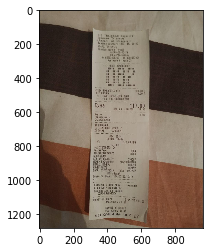

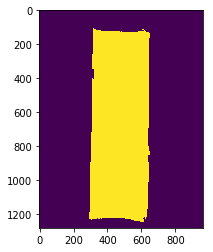

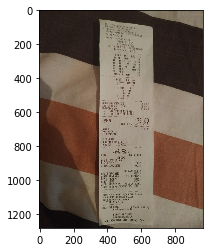

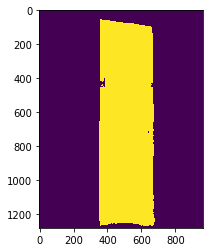

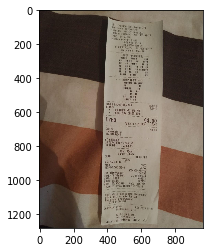

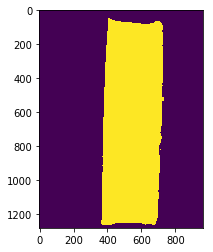

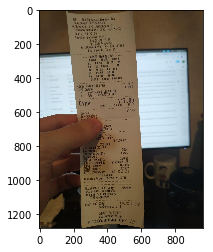

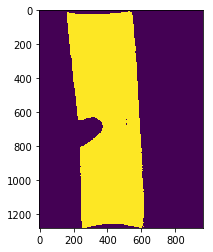

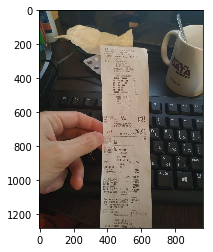

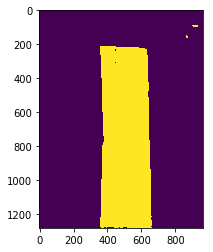

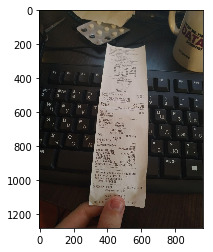

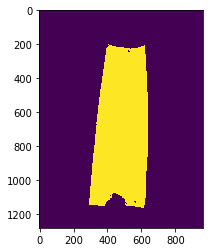

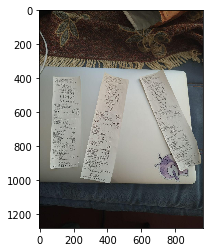

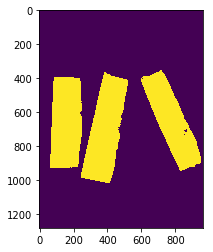

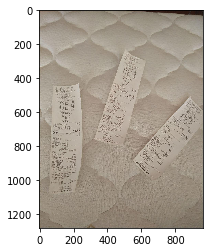

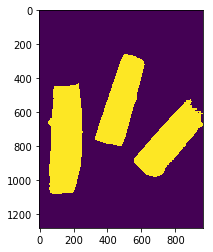

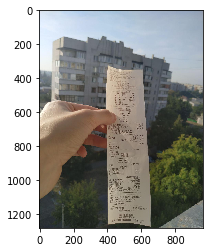

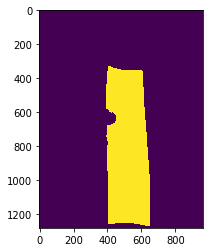

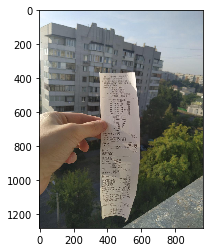

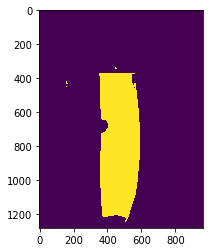

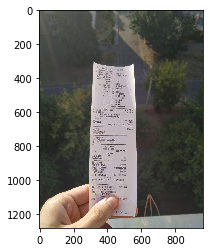

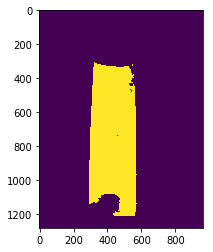

In [6]:
preds = model.predict(X)

preds = np.where(preds > 0.5, 1, 0)
preds = [p.reshape((p.shape[0], p.shape[1])) for p in preds]

for i, p in enumerate(preds):
    pyplot.figure()
    pyplot.imshow(X[i])
    pyplot.figure()

    pyplot.imshow(p)

In [7]:
idx = 2
mask = preds[idx].copy()
mask[0:3, :] = 0
mask[:, 0:3] = 0
mask[mask.shape[0]-3:mask.shape[0], :] = 0
mask[:, mask.shape[1]-3:mask.shape[1]] = 0
mask = np.uint8(mask * 255)

In [8]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [9]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

In [10]:
markers = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB),markers)
markers = np.where(markers!=1, 1, 0)
ret, m2 = cv2.threshold(markers.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
m2[0:3, :] = 0
m2[:, 0:3] = 0
m2[m2.shape[0]-3:mask.shape[0], :] = 0
m2[:, m2.shape[1]-3:mask.shape[1]] = 0

In [11]:
contours = cv2.findContours(m2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
cnts = imutils.grab_contours(contours)
cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
peri = cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)

In [12]:
res = cv2.drawContours(X[idx].copy(), [cnt], -1, (0, 255, 0), 2)

In [13]:
rect = cv2.minAreaRect(cnt)

box = cv2.boxPoints(rect)

src_pts = np.array(box)
print(rect[2])
if rect[2] >= -45:
    dst_pts = np.array([[0, 1000],   [0, 0], [300, 0], [300, 1000]], dtype=np.float32)
else:
    dst_pts = np.array([[300, 1000], [0, 1000], [0, 0], [300, 0],], dtype=np.float32)
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(X[idx], M, (300, 1000))

-88.13737487792969


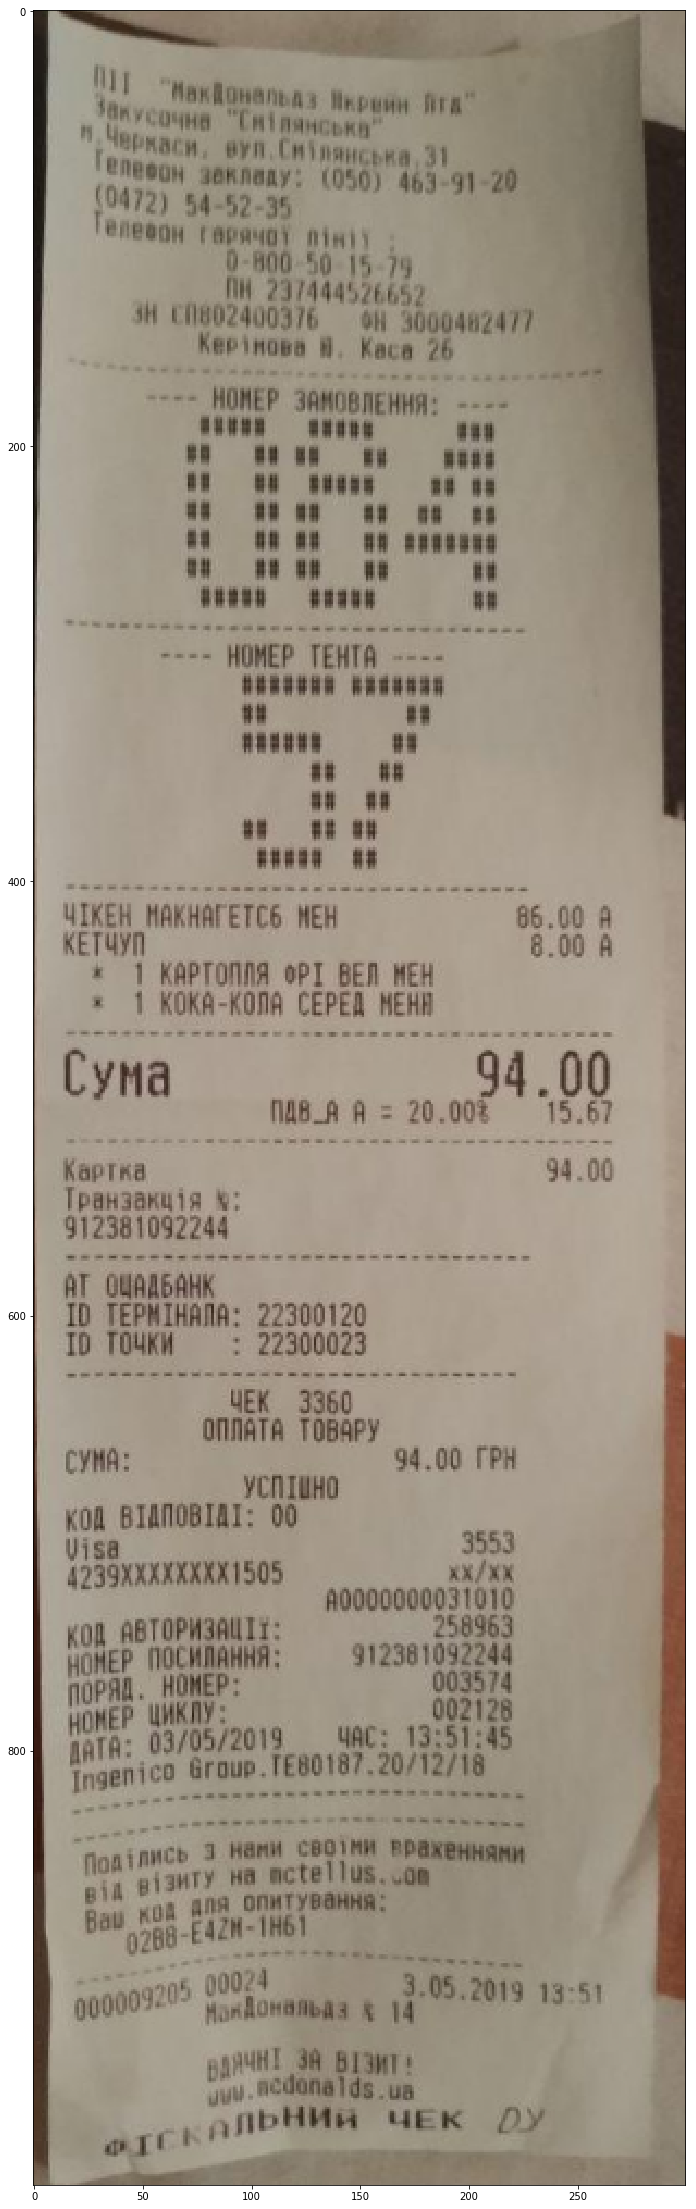

In [14]:
pyplot.figure(figsize=(40, 40))
pyplot.imshow(warp)

In [33]:
right_top = left_bottom = right_bottom = left_top = approx[0][0]
for p in approx:
    p = p[0]
    if p[0] + p[1] < left_top[0] + left_top[1]:
        left_top = p
    if p[0] + p[1] > right_bottom[0] + right_bottom[1]:
        right_bottom = p
    if p[0] - p[1] > left_bottom[0] - left_bottom[1]:
        left_bottom = p
    if -p[0] + p[1] > -right_top[0] + right_top[1]:
        right_top = p

In [34]:
left_top, right_top, right_bottom, left_bottom

(array([323, 306], dtype=int32),
 array([ 292, 1129], dtype=int32),
 array([ 552, 1212], dtype=int32),
 array([553, 386], dtype=int32))

In [35]:
src_pts = np.array([left_top, right_top, right_bottom, left_bottom], dtype=np.float32)
dst_pts = np.array([[0, 0],   [0, 1000],  [300, 1000], [300, 0]], dtype=np.float32)
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(X[idx], M, (300, 1000))

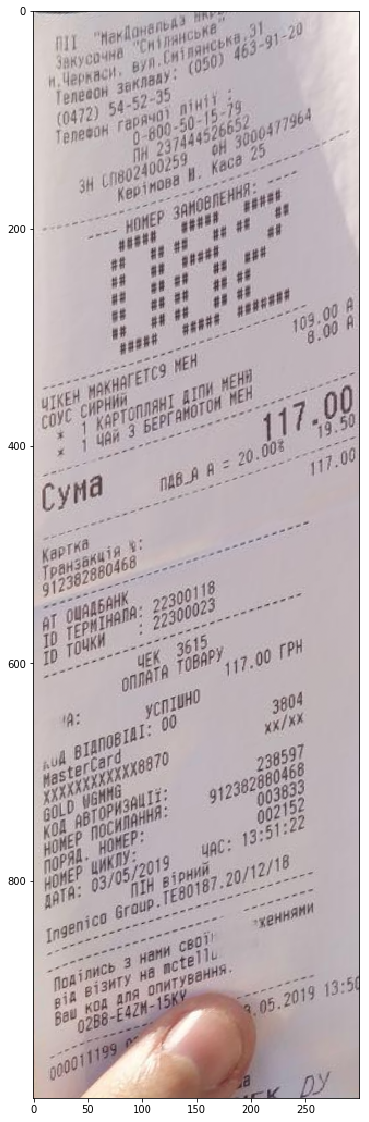

In [36]:
pyplot.figure(figsize=(20, 20))
pyplot.imshow(warp)

In [37]:
gray = cv2.cvtColor(warp.astype(np.float32), cv2.COLOR_RGB2GRAY)
gray = cv2.bitwise_not(gray).astype('uint8')

In [38]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [39]:
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
 
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle

In [40]:
angle

-0.0

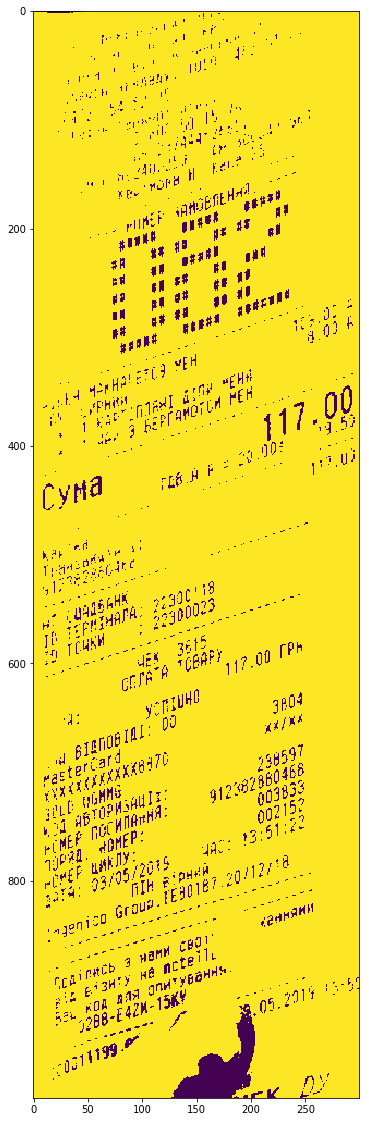

In [41]:
pyplot.figure(figsize=(20, 20))
pyplot.imshow(thresh)